<a href="https://colab.research.google.com/github/Ads369/Ads_2s/blob/main/ipynb/Lesson%2026/26_3_%D0%92%D0%B2%D0%B5%D0%B4%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B2_FastAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Навигация по уроку**

1. [Веб-архитектура сервиса](https://colab.research.google.com/drive/10wtDodlf4SaVcYk6VoXDWk650IDcNPaa)
2. [Практическое использование REST API в Python](https://colab.research.google.com/drive/1bhlFqhZp0TtOuzqKJvI9C-K0FwRWMi2H)
3. Введение в FastAPI
4. [Домашняя работа](https://colab.research.google.com/drive/1SlJW51-OaUUDPuk-j9GYNHHwFkHBztU_)

В третьей части урока будет создан веб-сервис, предоставляющий API для работы с вашей моделью нейронной сети.

## Создание веб-сервиса с помощью FastAPI

Существует большое количество веб-фреймворков, позволяющих создать веб-сервис с использованием языка Python, например, **Flask** или **Django**. Однако последние содержат слишком много функций для разработки веб-приложений, которые используют "лишний", для нас нейронщиков функционал.

Нас интересует только REST API, а значит будем использовать специализированным веб-фреймворком, который был разработан специально для создания API - **FastAPI**.


[FastAPI](https://fastapi.tiangolo.com/) — это фреймворк для создания лаконичных и довольно быстрых HTTP API-серверов со встроенными валидацией, сериализацией и асинхронностью, что называется, из коробки. Стоит он на плечах двух других фреймворков:
* работой с web в FastAPI занимается **Starlette**;
* за валидацию отвечает **Pydantic**.

Такой микс получился легковесным, неперегруженным и более, чем достаточным по функционалу.

Для работы **FastAPI** необходим **ASGI**-сервер, по дефолту документация предлагает **uvcorn**, базирующийся на **uvloop**, однако **FastAPI** также может работать и с другими серверами, например, c **hypercorn**. Эта информация дается исключительно для справки и не требует погружения в предметную область. В крупных компаниях этими вопросами занимаются системные администраторы, сетевики и службы безопасности. Нам лишь достаточно разобрать, что же такое ASGI?




### Что такое ASGI?

**ASGI** можно рассматривать как связующее звено, которое позволяет асинхронным Python серверам и приложениям взаимодействовать друг с другом. Он повторяет множество архитектурных идей из **WSGI**, и зачастую представляется как его преемник со встроенной асинхронностью.

> **WSGI-серверы** - появились потому, что веб-серверы в то время не умели взаимодействовать с приложениями, написанными на языке Python. WSGI был разработан в начале 2000-х годов, когда python еще не был асинхронным, представлял собой модуль к веб-серверу Apache (известный как `mod_python`). На тот момент по такой схеме работало большинство Python-приложений в Web.  Однако `mod_python` не был официальной спецификацией. Он был просто создан, чтобы разработчики могли запускать код Python на сервере. К сожалению, такой подход был небезопасным и разработчики начали искать новое решение. В свою очередь **WSGI (Web-Server Gateway Interface)** является потомком **CGI (Common Gateway Interface)**. CGI пытался поддержкивать большое число языков был медленным и ограниченным, но другого решения не было. WSGI был разработан как интерфейс для маршрутизации запросов от веб-серверов (Apache, Nginx и т.д.) на веб-приложения.

Погружаться в историю "древних технологий" мы не будем, а то так дойдем до истории создания интернета. Для нас самое важное, что с включением в Python библиотеки `asyncio`, началась "золотая лихорадка" вокруг параллелизма в Python. Сообщество начало буквально "асинхронизовывать" все вокруг. Если вам интересно, многие из получившихся проектов перечислены в [aio-libs](https://github.com/aio-libs) и [awesome-asyncio](https://github.com/timofurrer/awesome-asyncio).

Для нас важно уяснить, что веб-серверы и приложения на Python движутся в сторону асинхронности.

Вернемся к **ASGI**. На очень высоком уровне **ASGI** — это интерфейс для коммуникации между приложениями и серверами:

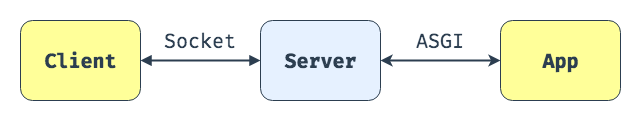

Но на самом деле, все немного сложнее.

Чтобы разобраться, как ASGI действительно работает, давайте взглянем на [спецификацию ASGI](https://asgi.readthedocs.io/en/latest/specs/main.html#overview).


ASGI состоит из двух различных компонентов:

* **Сервера протокола (protocol server)** — слушает сокеты и преобразует их в соединения и сообщения о событиях внутри каждого соединения.
* **Приложения (application)**, которое живет внутри сервера протокола (Protocol server), его экземпляр создается один раз для каждого соединения и обрабатывает сообщения о событиях (Event messages) по мере их возникновения.

Таким образом, согласно спецификации, то, что действительно указывает ASGI — это формат сообщения и то, как эти сообщения должны передаваться между приложением и сервером протокола, который его запускает.


Теперь мы можем составить более детальную версию диаграммы:



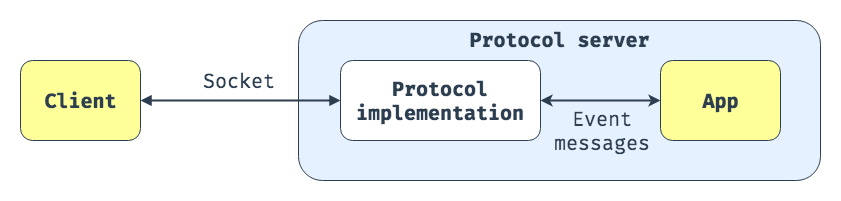

**ASGI** опирается на простую модель: когда клиент подключается к серверу, создается экземпляр приложения. Затем входящие данные передаются в приложение и отправляются обратно все данные, которые оно возвращает.

Передача данных в приложение здесь в действительности означает вызов приложения, как если бы оно было функцией, т.е. чем-то, что принимает некоторые входные данные и возвращает выходные.

На самом деле, все, что представляет собой **ASGI**-приложение — это асинхронная функция,  параметры которой, определяются спецификацией **ASGI**:

```python
async def app(scope, receive, send):
    ...

```

Рассмотрим параметры функции:


* `scope` — это словарь, содержащий информацию о входящем запросе. Его содержимое отличается для HTTP и WebSocket соединений.
* `receive` — асинхронная функция для получения сообщений о событиях ASGI.
* `send` — асинхронная функция для отправки сообщений о событиях ASGI.

По сути, эти параметры позволяют получать (`receive()`) и передавать (`send()`) данные по каналу связи, который поддерживает сервер протокола, а также понимать, в каком контексте (или `scope`) этот канал был создан.



Краткий рассказ про ASGI подошел к концу. Если вы хотите узнать больше о ASGI, ознакомьтесь с различными [публикациями](https://github.com/florimondmanca/awesome-asgi#publications) (статьями и выступлениями), перечисленными в `awesome-asgi`.

###Первые шаги FastAPI

Для начала разберемся, как создавать веб-сервисы с помощью **FastAPI** и обращаться к созданному API.

Установим библиотеку **FastAPI** и вспомогательные компоненты:

In [ ]:
!pip install fastapi # Установим FastAPI
!pip install uvicorn # Установим ASGI-сервер
!pip install python-multipart # Необходимая зависимость для FastAPI (для работы с данными отправленных форм на сайте)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.4/341.4 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Создадим файл с тестовым API:

In [ ]:
%%writefile main.py
# импортируем FastAPI
from fastapi import FastAPI

# Создаем экземпляр класса FastAPI
app = FastAPI()

# Объявляем функцию get_test() и декоратор для метода GET
@app.get("/test")
def get_test():
    return {"Hello": "World"}

Overwriting main.py


Все начинается с создания экземпляра главного класса **FastAPI**, который в свою очередь наследуется от класса **Starlette**.

**Starlette** выполняет всю основную работу по разрешению запросов.

**FastAPI** создает декораторы, которые отправляют роуты в класс **Starlette**. Эти роуты хранятся там до запроса.

Когда происходит запрос к хосту на котором запущено приложение **FastAPI** вместе с **ASGI-фреймворком**, приложение получает три параметра `scope`, `receive` и `send`.


Для обработки запросов к приложения мы создали объект приложения с помощью конструктора **FastAPI** из пакета `fastapi`:

```python
app = FastAPI()
```

Затем определяем функцию, которая будет обрабатывать запросы. К этой функции применяется специальный декоратор в виде метода `app.get()`:

```python
@app.get("/test")
```

В этот метод передается шаблон маршрута, по которому функция будет обрабатывать запросы. Его также назвают **endpoint** (эндпойнт) - конечная точка на маршруте запроса. В данном случае это строка "/test", которая означает, что функция будет обрабатывать запросы по пути `/test` веб-приложения.

После декоратора `app.get` идет собственно определение функции (хэндлера), которая обрабатывает запрос:

```python
def get_test():
    return {"Hello": "World"}
```    

Запустим HTTP-сервер **uvicorn** с указанием приложения, которое будет запускаться (**app** из файла **main.py**):

In [ ]:
!nohup uvicorn main:app --reload &
# nohup и & - прописываются для запуска процесса в фоне (чтобы не блокировать Colab)
# параметр --reload позволяет автоматически перезапускать uvicorn при изменениях в файле main.py

nohup: appending output to 'nohup.out'


Логи HTTP-сервера теперь выводятся в файл **nohup.out**:

In [ ]:
!cat nohup.out

Как мы видим из логов, наш веб-сервер запустился по адресу http://127.0.0.1:8000, т.е. локально на том сервере, где запущен, на 8000 порту и не виден никому в интернете больше. Для разработки и отладки приложения - это то, что нам и нужно!

Теперь мы уже умеем пользоваться библиотекой `requests` и можем отправить пробный запрос к созданному эндпойнту:

In [ ]:
import requests
r = requests.get('http://127.0.0.1:8000/test')
print(r.status_code)
print(r.text)

200
{"Hello":"World"}


При возникновении ошибки просто перезапустите ячейку.

Однако, мы не можем обратиться к нашему API из браузера. Если мы в браузере укажем адрес http://127.0.0.1:8000/test, то мы обратимся к локальному адресу нашего компьютера, а должны к локальному адресу сервера, где выполняется наш код.

Прежде чем продолжить изучать FastAPI нам необходимо получить прямой доступ к нашему веб-серверу. Для этого воспользуемся сервисом **Serveo.net**.

### Serveo.net и localhost.run

In [ ]:
!ssh -o "StrictHostKeyChecking no" -R 80:localhost:8000 serveo.net

Forwarding HTTP traffic from https://e26c738cb044f560a3eaa7cadb490ad6.serveo.net
HTTP request from 194.5.60.220 to https://e26c738cb044f560a3eaa7cadb490ad6.serveo.net/
HTTP request from 194.5.60.220 to https://e26c738cb044f560a3eaa7cadb490ad6.serveo.net/favicon.ico
HTTP request from 194.5.60.220 to https://e26c738cb044f560a3eaa7cadb490ad6.serveo.net/html


**Serveo.net** — это сервис, который позволяет вам прокинуть наружу (в интернет) порт, присвоить ему временное имя и подключаться по этому имени к вашему локальному веб-сервису из вне (интернета).
Фактически это SSH-сервер, предназначенный только для удаленной переадресации портов. Когда пользователь подключается к Serveo, он получает общедоступный URL-адрес, который можно использовать для подключения к своему локальному веб-серверу. Важно помнить, что это публичный адрес, доступный всем.

Магическая команда `!ssh` запускает SSH-клиента.
>**SSH-клиент** — это программа на стороне клиента, с помощью которой он осуществляет подключение к удаленной машине.

Рассмотрим команду:

`!ssh -o "StrictHostKeyChecking no" -R 80:localhost:8000 serveo.net`.

Опция `-o "StrictHostKeyChecking no"`, указывает на то, что необходим отключить строгую проверку ключа хоста. Если бы не данная чудодейственная таблетка, нам пришлось бы научиться генерировать ключи и сертификаты, изучать "курс молодого системного администратора" с основами туннелирования и проброса портов. Это, конечно же, очень интересно и захватывающе, мы смогли бы "прогуляться" по серверам Google и собрать много интересной информации, но к сожалению это выходит за рамки курса, а также грозит блокировкой учетной записи Google и ограничением на использование Colab.

Опция `-R` указывает на то, что ваш SSH-клиент для запроса переадресации портов с сервера и прокси-запросов на указанный хост и порт (в нашем случае это `localhost:8000`, что эквивалентно `127.0.0.1:8000`). Поддомен **serveo.net** назначается для перенаправления HTTP-трафика (80 порт - это http порт по умолчанию).


После запуска команды вы увидите сообщение:

`Forwarding HTTP traffic from https://8b0ab92b66c80e591f748257cb4e1727.serveo.net`

Это говорит о том, что **Serveo** выделил вам поддомен `8b0ab92b66c80e591f748257cb4e1727` для доступа к вашему веб-серверу. При каждом запуске будет генерироваться новый случайный поддомен.

Теперь вы можете вбить в своем браузере в адресной строке:
`https://8b0ab92b66c80e591f748257cb4e1727.serveo.net/test`

И получить ответ:

`{"Hello":"World"}`

Аналогично **serveo.net** есть и другие подобные сервисы. Бесплатно они предоставляют ограниченное количество времени, на которое вы можете "поднять туннель". Если ваше время с **serveo.net** подошло к концу (либо из-за частых обращений к сервису вас заблокировали на сутки, а такое тоже бывает), то запустите туннель до альтернативного сервиса **localhost.run**:

In [ ]:
!ssh -o "StrictHostKeyChecking no" -R 80:localhost:8000 nokey@localhost.run


Welcome to localhost.run!

Follow your favourite reverse tunnel at [https://twitter.com/localhost_run].

To set up and manage custom domains go to https://admin.localhost.run/

More details on custom domains (and how to enable subdomains of your custom
domain) at https://localhost.run/docs/custom-domains

If you get a permission denied error check the faq for how to connect with a key or
create a free tunnel without a key at [http://localhost:3000/docs/faq#generating-an-ssh-key].

To explore using localhost.run visit the documentation site:
https://localhost.run/docs/


** your connection id is dbfb6289-3ae2-43ab-9927-f25196b638e5, please mention it if you send me a message about an issue. **

authenticated as anonymous user
d307584938f0b5.lhr.life tunneled with tls termination, https://d307584938f0b5.lhr.life
create an account and add your key for a longer lasting domain name. see https://localhost.run/docs/forever-free/ for more information.
Open your tunnel address on your mobile w

Только формат адреса теперь будет другой: `https://37880a7bb31b37.lhr.life` и не забывайте, что это адрес до веб-сервера, соответственно, необходимо добавлять endpoint "/test" для обращения к функции `get_test()`.

### Автоматическая документация API

Убедитесь, что ваш веб-сервис запущен на 80 порту командой `!nohup uvicorn main:app --reload &` и запущен туннель до сервиса **serveo.net** или **localhost.run**. Теперь если вы добавите endpoint `/docs` к адресу сервиса (в нашем случае `https://8b0ab92b66c80e591f748257cb4e1727.serveo.net/docs, у вас будет немного другой поддомен), то уведите страницу с документацие, как на скрине ниже.

Это интерактивная документация по API, которая сформирована с помощью [Swagger UI](https://github.com/swagger-api/swagger-ui).


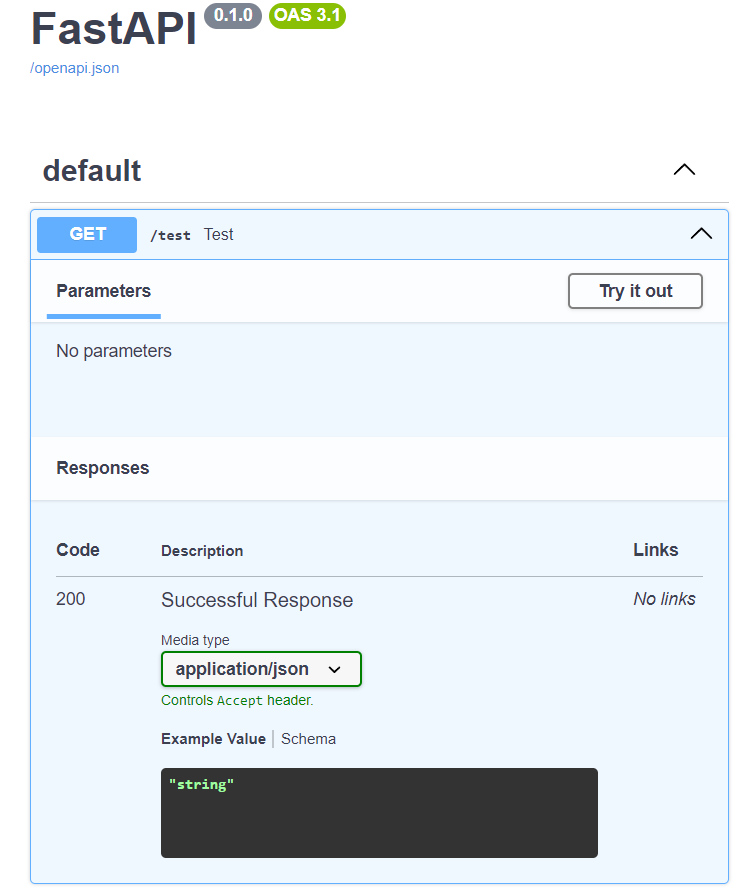

Но это не все! **FastAPI** сформирует для вас и альтернативную документацию API с помощью инструмента [ReDoc](https://github.com/Rebilly/ReDoc). Для этого необходимо обратиться в браузере к эндпойнту `/redoc`.


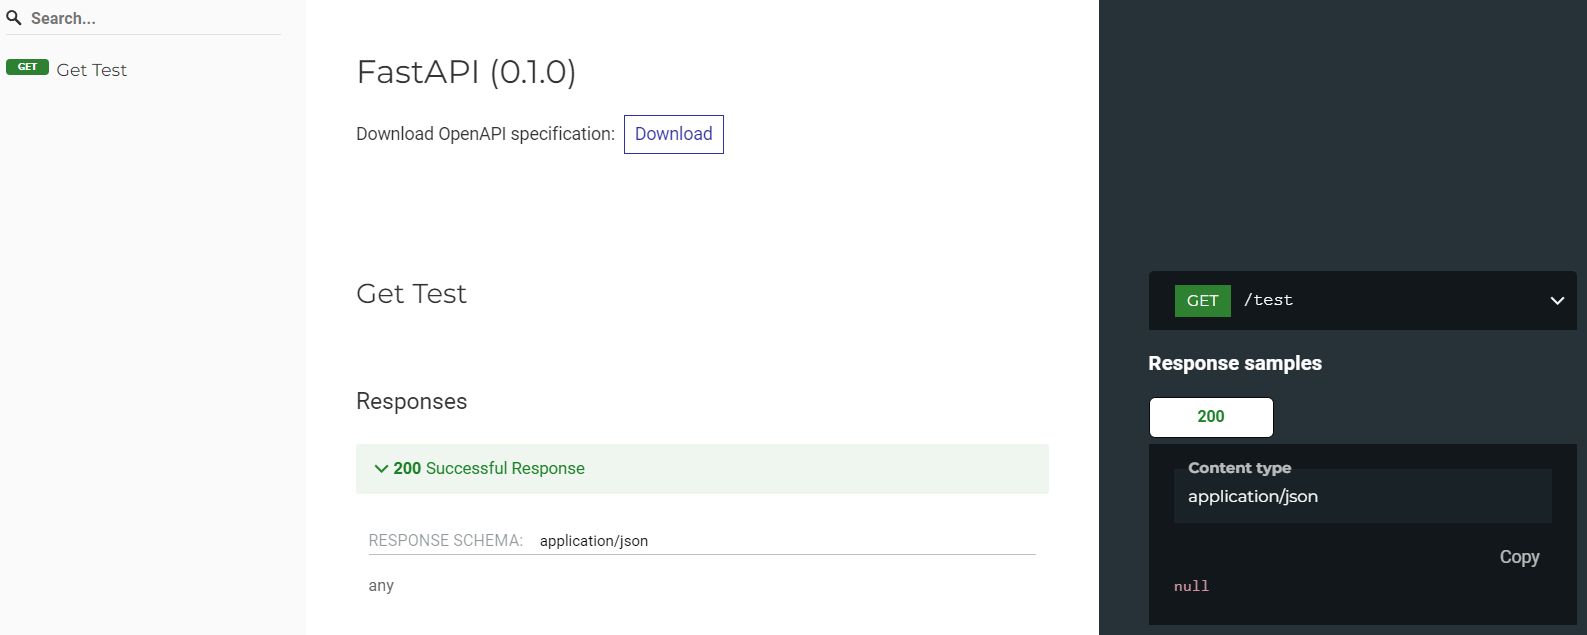

На этом чудеса документации FastAPI не заканчиваются. Помните, когда мы говорили про Yandex.Cloud, то упоминали про формат OpenAPI (не путать с OpenAI)? Оказывается, что документацию FastAPI умеет генерировать и в этом формате, достаточно обратится к эндпойнту `/openapi.json`:

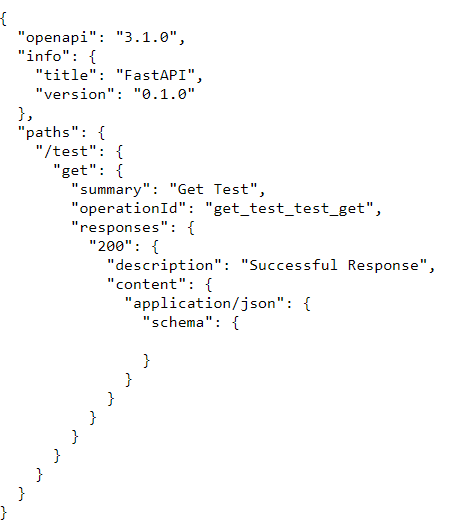

**FastAPI** автоматически генерирует документацию к нашим эндпойнтам, которые мы создаем, наша задача ему немного помочь и добавить описание.

Давайте перепишем наш модуль `main.py`, создадим в нем простейшее REST API для работы с простым набором объектов и задокументируем API.

### Создание простейшего REST API

#### Отправка ответа

Наш модуль `main.py` умеет отправлять ответ только в виде словаря **dict** (функция `get_test()`), который содержит один ключ `Hello`. При отправке эти данные автоматически сериализуются в формат JSON (популярный формат для взаимодействия между клиентом и сервером). А у ответа для заголовка `content-type` устанавливается значение `application/json`.

Вообще функция может возвращать различные данные - словари, списки, одиночные значения типа строк, чисел и т.д., которые затем сериализуются в JSON с помощью кодировщика `fastapi.encoders.jsonable_encoder`. А для отправки ответа FastAPI по умолчанию использует класс `fastapi.responses.JSONResponse`. То есть предыдущий код в принципе будет эквивалентен следующему:

In [ ]:
%%writefile main.py
# импортируем FastAPI
from fastapi import FastAPI
from fastapi.responses import JSONResponse
from fastapi.encoders import jsonable_encoder

# Создаем экземпляр класса FastAPI
app = FastAPI()

# Метод GET, эндпойнт /test
@app.get("/test")
def get_test():
    data = {"Hello": "World"}
    json_data = jsonable_encoder(data)      # сериализуем данные
    return JSONResponse(content=json_data)  # отправка ответа в формате JSON

Параметр `content` задает отправляемые данные. Можно без явной сериализации передать данные в `JSONResponse`:

In [ ]:
%%writefile main.py
# импортируем FastAPI
from fastapi import FastAPI
from fastapi.responses import JSONResponse
from fastapi.encoders import jsonable_encoder

# Создаем экземпляр класса FastAPI
app = FastAPI()

# Метод GET, эндпойнт /test
@app.get("/test")
def get_test():
    return JSONResponse(content={"Hello": "World"})  # отправка ответа в формате JSON

Overwriting main.py


Глядя на 2 последних примера, возникает справедливый вопрос, а зачем тогда использовать сериализатор, если можно без него? Когда вы начнете работать со сложными классами, то столкнетесь с проблемой сериализации из тех или иные атрибутов, которые являются тоже классами или сложными составными типами данных. Т.е. если нам необходимо отправить какие-то нестандартные несериализуемые данные или, если нас не устраивает сериализация по умолчанию, мы можем определить свой сериализатор JSON, заменив `jsonable_encoder` на свой метод.

Важно отметить, что функция необязательно должна возвращать именно данные в формате JSON. В реальности мы можем возвратить объект класса **Response** или одного из его подклассов (которым также является **JSONResponse**), которые позволяют отправлять клиенту ответ в различных видах и формах. Рассмотрим некоторые из этих классов.

**Response**

Класс **fastapi.Response** является базовым для остальных классов ответа. Его преимуществом является то, что он позволяет также отправить ответ, который не покрывается встроенными классами, например, в каком-то нестандартном формате.

Для определения ответа конструктор класса принимает следующие параметры:

* **content** - задает отправляемое содержимое;

* **status_code** - задает статусный код ответа;

* **media_type** - задает MIME-тип ответа;

* **headers** - задает заголовки ответа.

Рассмотрим простейший пример:

In [ ]:
%%writefile main.py
from fastapi import FastAPI, Response

app = FastAPI()


@app.get("/hello")
def hello():
    data = "Hello World!"
    return Response(content=data, media_type="text/plain")

Overwriting main.py


В данном случае клиенту отправляет обычная строка "Hello World!". А MIME-тип `text/plain` указывает, что тип ответа - простой текст.

> Медиа тип (так же известный как Multipurpose Internet Mail Extensions или MIME тип) является стандартом, который описывает природу и формат документа, файла или набора байтов. Он определён и стандартизирован в спецификации **RFC 6838**.

Как мы уже видели в прошлой части урока `Content-Type` содержит информацию о MIME-типе и кодировке, разделенных точкой с запятой (;).

**PlainTextResponse**

Для отправки простого текста также можно использовать класс-наследник **PlainTextResponse** от **Response**:

In [ ]:
%%writefile main.py
from fastapi import FastAPI
from fastapi.responses import PlainTextResponse

app = FastAPI()

@app.get("/text")
def get_text():
    data = "Hello World!"
    return PlainTextResponse(content=data)

Overwriting main.py


При этом `media_type` указывать не нужно, он заранее определен в классе-наследнике.

**HTMLResponse**

Для упрощения отправки кода в формате HTML предназначен класс **HTMLResponse**. Он устанавливает для заголовка `Content-Type` значение `text/html`:



In [ ]:
%%writefile main.py
from fastapi import FastAPI
from fastapi.responses import HTMLResponse

app = FastAPI()

@app.get("/html")
def get_html():
    data = "<h2>Hello World!</h2>"
    return HTMLResponse(content=data)

Overwriting main.py


В браузере вы увидитете такую надпись (если запустите веб-сервис и пробросите порты к сервису):

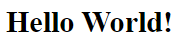

**Установка типа ответа через методы FastAPI**

Методы **FastAPI** такие как `get()`, `post()` и т.д. позволяют задать тип ответа с помощью параметра `response_class`:

In [ ]:
%%writefile main.py
from fastapi import FastAPI
from fastapi.responses import PlainTextResponse, JSONResponse, HTMLResponse

app = FastAPI()

@app.get("/text", response_class = PlainTextResponse)
def get_text():
    return "Hello World!"

@app.get("/html", response_class = HTMLResponse)
def get_html():
    return "<h2>Hello World!</h2>"

@app.get("/json", response_class = JSONResponse)
def get_json():
    return { "message": "Hello World!" }

#### Отправка статусных кодов

По умолчанию функции обработки отправляют статусный код `200`, но при необходимости мы можем отправить любой статусный код. Для этого у методов `get()`, `post()`, `put()`, `delete()`, `options()`, `head()`, `patch()`, `trace()` в классе **FastAPI** применяется параметр `status_code`, который принимает числовой код статуса HTTP.

Например:

In [ ]:
%%writefile main.py
from fastapi import FastAPI

app = FastAPI()

@app.get("/notfound", status_code=404)
def notfound():
    return  {"message": "Resource Not Found"}

В данном случае при обращении по пути `/notfound` клиенту отправляется статусный код ошибки `404`, который говорит о том, что ресурс не найден.

##### **Определение статусного кода в ответе**

В примере выше функция вне зависимости от данных запроса или каких-то других условий в любом случае возвращала статусный код `404`. Однако чаще бывает необходимо возвращать статусный код в зависимости от некоторых условий. В этом случае мы можем использовать параметр `status_code` конструктора класса **Response** или его наследников:

In [ ]:
%%writefile main.py
from fastapi import FastAPI
from fastapi.responses import JSONResponse

app = FastAPI()

@app.get("/notfound")
def notfound():
    return JSONResponse(content={"message": "Resource Not Found"}, status_code=404)

##### **Изменение статусного кода**

Можно комбинировать оба подхода и изменять статусный код на лету.

In [ ]:
%%writefile main.py
from fastapi import FastAPI, Response, Path

app = FastAPI()

@app.get("/users/{id}", status_code=200)
def users(response: Response, id: int = Path()):
    if id < 1:
        response.status_code = 400
        return {"message": "Incorrect Data"}
    return  {"message": f"Id = {id}"}

Overwriting main.py


Обратите внимание на эндпойнт `/users/{id}` он содержит параметр `id`, который принято называть **параметр пути**.



В данном случае если параметр пути меньше 1, то условно считаем, что переданные некорректные данные, и отправляем в ответ статусный код `400 (Bad Request)`.

Давайте выполним запрос к нашему веб-серверу, указав 2 разных параметра пути равные 1 и 0:

In [ ]:
import requests
r = requests.get('http://127.0.0.1:8000/users/1')
print('Код статуса запроса: ', r.status_code)
print('Content-Type: ', r.headers['Content-Type'])
print('Ответ:')
print(r.json())

Код статуса запроса:  200
Content-Type:  application/json
Ответ:
{'message': 'Id = 1'}


In [ ]:
r = requests.get('http://127.0.0.1:8000/users/0')
print('Код статуса запроса: ', r.status_code)
print('Content-Type: ', r.headers['Content-Type'])
print('Ответ:')
print(r.json())

Код статуса запроса:  400
Content-Type:  application/json
Ответ:
{'message': 'Incorrect Data'}


Функция `users()`, которая обрабатывает запрос по этому пути, принимает 2 параметра **Response** - для управления ответом и параметр `id`, переданный в пути запроса. Фреймворк автоматически свяжет параметры пути (их может быть несколько) и параметры функции. В нашем случае фреймворк определит параметр пути `{id}` как параметр функции `id`.

Чтобы указать, что параметр - целое число, у параметра функции явным образом задается тип `int`. И если мы попробуем передать этому параметру не целочисленное значение, то сервер отправит сообщение об ошибке:

In [ ]:
r = requests.get('http://127.0.0.1:8000/users/one')
print('Код статуса запроса: ', r.status_code)
print('Content-Type: ', r.headers['Content-Type'])
print('Ответ:')
print(r.json())

Код статуса запроса:  422
Content-Type:  application/json
Ответ:
{'detail': [{'type': 'int_parsing', 'loc': ['path', 'id'], 'msg': 'Input should be a valid integer, unable to parse string as an integer', 'input': 'one'}]}


Подобным образом в качестве ограничения можно использовать и другие типы: `str`, `float`, `bool` и ряд других.

#### Валидация значений

Дополнительно для работы с параметрами пути фреймворк **FastAPI** предоставляет класс **Path** из пакета `fastapi`. Класс **Path** позволяет валидировать значения параметров. В частности, через конструктор **Path** можно установить следующие параметры для валидации значений:

* **min_length** - устанавливает минимальное количество символов в значении параметра.

* **max_length** - устанавливает максимальное количество символов в значении параметра.

* **pattern** - устанавливает регулярное выражение, которому должно соответствовать значение параметра.

* **lt** - значение параметра должно быть меньше определенного значения.

* **le** - значение параметра должно быть меньше или равно определенному значению.

* **gt** - значение параметра должно быть больше определенного значения.

* **ge** - значение параметра должно быть больше или равно определенному значению.

In [ ]:
%%writefile main.py
from fastapi import FastAPI, Response, Path

app = FastAPI()

# так как мы используем ASGI, то поддержка асинхронности на гарантируется, поэтому будем добавлять async к функциям
@app.get("/users/{name}/{age}")
async def users(name: str = Path(min_length=3, max_length=20), age: int = Path(gt=0, lt=120)):
    return {"user_name": name, "user_age": age}

Overwriting main.py


In [ ]:
r = requests.get('http://127.0.0.1:8000/users/Vasya/32')
print('Код статуса запроса: ', r.status_code)
print('Content-Type: ', r.headers['Content-Type'])
print('Ответ:')
print(r.text)

Код статуса запроса:  200
Content-Type:  application/json
Ответ:
{"user_name":"Vasya","user_age":32}


In [ ]:
r = requests.get('http://127.0.0.1:8000/users/Ve/180')
print('Код статуса запроса: ', r.status_code)
print('Content-Type: ', r.headers['Content-Type'])
print('Ответ:')
print(r.text)

Код статуса запроса:  422
Content-Type:  application/json
Ответ:
{"detail":[{"type":"string_too_short","loc":["path","name"],"msg":"String should have at least 3 characters","input":"Ve","ctx":{"min_length":3}},{"type":"less_than","loc":["path","age"],"msg":"Input should be less than 120","input":"180","ctx":{"lt":120}}]}


#### Получение данных из тела запроса

В запросе могут передаваться различные данных, например, через отправку каких-то значений в формате  JSON. Рассмотрим, как получать подобные данные.


In [ ]:
%%writefile main.py
from fastapi import FastAPI, Body

app = FastAPI()

@app.post("/user/data")
async def hello_data(data = Body()):
    name = data["name"]
    age = data["age"]
    return {"message": f"{name}, ваш возраст - {age}"}

@app.post("/user/embed")
async def hello_embed(name = Body(embed=True), age = Body(embed=True)):
    return {"message": f"{name}, ваш возраст - {age}"}

Overwriting main.py


Для обработки полученных в POST-запросе данных по адресу `/user/data` определена функция `hello_data()`. Эта функция имеет один параметр - `data`, который получает содержимое тела запроса:

```python
data = Body()
```

То есть здесь `data` будет представлять весь объект, который отправляется с веб-страницы и который имеет свойства `name` и `age`. Этот объект в python будет представлять словарь.

Соответственно, чтобы получить значения свойства `name`, обращаемся по одноименному ключу:

```python
name = data["name"]
```

Подобным образом получаем значение свойства `age`. Затем в ответ клиенту посылается словарь с элементом `message`.

Cуществует и более удобный метод получения данных из тела запроса. В примере выше мы получали все данные из тела запроса в один параметр. Однако, установив параметр `embed=True`, можно получать отдельные значения:

```python
def hello_embed(name = Body(embed=True), age = Body(embed=True)):
    return {"message": f"{name}, ваш возраст - {age}"}    
```

Запустим веб-сервер снова:

In [ ]:
!nohup uvicorn main:app --reload &
# nohup и & - прописываются для запуска процесса в фоне (чтобы не блокировать Colab)
# параметр --reload позволяет автоматически перезапускать uvicorn при изменениях в файле main.py

nohup: appending output to 'nohup.out'


Проверим работу обоих методов:

In [ ]:
r = requests.post('http://127.0.0.1:8000/user/data', json={'name': 'Vasya', 'age': 28})
print('Код статуса запроса: ', r.status_code)
print('Content-Type: ', r.headers['Content-Type'])
print('Ответ:')
print(r.text)

Код статуса запроса:  200
Content-Type:  application/json
Ответ:
{"message":"Vasya, ваш возраст - 28"}


In [ ]:
r = requests.post('http://127.0.0.1:8000/user/embed', json={'name': 'Vasya', 'age': 28})
print('Код статуса запроса: ', r.status_code)
print('Content-Type: ', r.headers['Content-Type'])
print('Ответ:')
print(r.text)

Код статуса запроса:  200
Content-Type:  application/json
Ответ:
{"message":"Vasya, ваш возраст - 28"}


Класс **Body** позволяет валидировать значения из тела запроса, аналогично **Path**. В частности, через конструктор **Body** можно установить следующие параметры для валидации значений:

* **min_length** - устанавливает минимальное количество символов в значении параметра.

* **max_length** - устанавливает максимальное количество символов в значении параметра.

* **pattern** - устанавливает регулярное выражение, которому должно соответствовать значение параметра.

* **lt** - значение параметра должно быть меньше определенного значения.

* **le** - значение параметра должно быть меньше или равно определенному значению.

* **gt** - значение параметра должно быть больше определенного значения.

* **ge** - значение параметра должно быть больше или равно определенному значению.

Для хэндлера `/user/embed` мы можем задать валидацию следующим путем:

```python
@app.post("/user/embed")
def hello_embed(name:str  = Body(embed=True, min_length=3, max_length=20), age: int = Body(embed=True, ge=0, lt=120)):
    return {"message": f"{name}, ваш возраст - {age}"}    
            


#### Получение данных из строки запроса

Параметры строки запроса представляют еще один способ передать в приложение некоторые значения в запросе типа GET.

Например, возьмем следующий адрес:

http://127.0.0.1:8000/users/?name=Peter&age=38

Для получения значений параметров строки запроса мы можем в функции определить одноименные параметры:

In [ ]:
%%writefile main.py
from fastapi import FastAPI

app = FastAPI()


@app.get("/users")
async def get_model(name: str = "NoName", age: int = 18): # определяем параметры, которые должны быть полученны из строки
    return {"user_name": name, "user_age": age}

Writing main.py


In [ ]:
import requests
r = requests.get('http://127.0.0.1:8000/users/?name=Peter&age=38')
print('Код статуса запроса: ', r.status_code)
print('Content-Type: ', r.headers['Content-Type'])
print('Ответ:')
print(r.text)

Код статуса запроса:  200
Content-Type:  application/json
Ответ:
{"user_name":"Peter","user_age":"38"}


Вполне может быть, что при обращении к приложению пользователь не передаст значения для какого-либо параметра или даже для всех параметров строки запроса. Чтобы в этом случае не было ошибок, мы задали значения по умолчанию для параметров. Также для параметров строки запроса мы задали ограничения по типу: **str** для `name` и **int** для `age`. Если параметру `age` передать нечисловое значение, то мы получим ошибку.




Дополнительно для работы с параметрами строки запроса фреймворк предоставляет класс **Query** из пакета `fastapi`. Класс **Query** позволяет прежде всего валидировать значения параметров строки запроса. В частности, через конструктор **Query** можно установить те же параметры для валидации значений, что и для **Body**. Для примера зададим для параметра `phone` (телефон) регулярное выражение `^\d{11}$`, которое означает, что номер состоит из 11 цифр, другие символы запрещены:

In [ ]:
%%writefile main.py
from fastapi import FastAPI, Query

app = FastAPI()

@app.get("/users")
async def users(phone:str  = Query(pattern=r"^\d{11}$", default='00000000000')):
    return {"phone": phone}

Overwriting main.py


In [ ]:
import requests
r = requests.get('http://127.0.0.1:8000/users/?phone=89012345678')
print('Код статуса запроса: ', r.status_code)
print('Content-Type: ', r.headers['Content-Type'])
print('Ответ:')
print(r.text)

Код статуса запроса:  200
Content-Type:  application/json
Ответ:
{"phone":"89012345678"}


**Query** позволяет установить значение по умолчанию с помощью параметра `default`. При запросе без параметра мы получим значение по умолчанию:

In [ ]:
import requests
r = requests.get('http://127.0.0.1:8000/users/')
print('Код статуса запроса: ', r.status_code)
print('Content-Type: ', r.headers['Content-Type'])
print('Ответ:')
print(r.text)

Код статуса запроса:  200
Content-Type:  application/json
Ответ:
{"phone":"00000000000"}


#### Создание модуля REST API

Давайте теперь попробуем объединить все полученные в данном уроке знания и написать модуль, поддерживающий все основные операции CRUD (создание, чтение, обновление и удаление). А также добавим элементы описания для документирования API.

Мы добавим 2 поля в декоратор:
* **description** - описание, что делает данный метод;

* **summary** - заголовок, что делает данный метод.

На примере метода `delete`

```python
@app.delete("/api/users/{id}",
    description="Удаление пользователя",
    summary="Удаление пользователя")
```

Это будет выглядеть следующим образом:

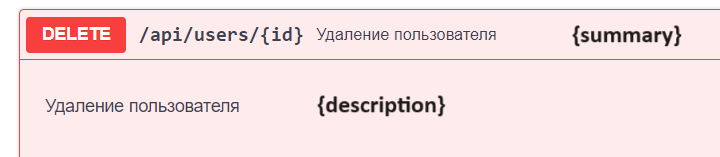

Сразу создадим модуль `main.py`, чтобы бы иметь всю схему перед глазами, а после разберем его по частям и обсудим:

In [ ]:
%%writefile main.py

import uuid # генератор случайного токена, как id пользователя
from fastapi import FastAPI, Body
from fastapi.responses import JSONResponse

# Определяем класс Person с полями:
#  name - имя
#  age  - возраст
#  id   - идентификатор пользователя
class Person:
    def __init__(self, name, age): # конструктор класса, вызывается при создании объекта
        self.name = name
        self.age = age
        self.id = str(uuid.uuid4()) # генерация токена в формате UUID4

# условная база данных - набор объектов Person
people = [Person("Vasya", 38), Person("Peter", 42), Person("Vova", 16),
          Person("Irina", 22), Person("Masha", 18), Person("Elena", 25)]

# для поиска пользователя в списке people
def find_person(id):
   for person in people:
        if person.id == id:
           return person
   return None

app = FastAPI()



@app.get("/api/users",
    summary="Список пользователей",
    description="Получение списка пользователей из базы"
    )
async def get_people():
    return people

@app.get("/api/users/{id}",
    summary="Пользователь",
    description="Получение пользователя по идентификатору")
async def get_person(id):
    # получаем пользователя по id
    person = find_person(id)
    print(person)
    # если не найден, отправляем статусный код и сообщение об ошибке
    if person==None:
        return JSONResponse(
                status_code=404,
                content={ "message": "Пользователь не найден" }
        )
    #если пользователь найден, отправляем его
    return person

@app.post("/api/users",
    summary="Создание пользователя",
    description="Добавление нового пользователя в базу данных")
async def create_person(data  = Body()):
    person = Person(data["name"], data["age"])
    # добавляем объект в список people
    people.append(person)
    return person

@app.put("/api/users",
    summary="Редактирование пользователя",
    description="Редактирование пользователя в базе данных")
async def edit_person(data  = Body()):
    # получаем пользователя по id
    person = find_person(data["id"])
    # если не найден, отправляем статусный код и сообщение об ошибке
    if person == None:
        return JSONResponse(
                status_code=404,
                content={ "message": "Пользователь не найден" }
        )
    # если пользователь найден, изменяем его данные и отправляем обратно клиенту
    person.age = data["age"]
    person.name = data["name"]
    return person


@app.delete("/api/users/{id}",
    summary="Удаление пользователя",
    description="Удаление пользователя из базы данных")
async def delete_person(id):
    # получаем пользователя по id
    person = find_person(id)

    # если не найден, отправляем статусный код и сообщение об ошибке
    if person == None:
        return JSONResponse(
                status_code=404,
                content={ "message": "Пользователь не найден" }
        )

    # если пользователь найден, удаляем его
    people.remove(person)
    return person

Writing main.py


Разберем в общих чертах этот код. Прежде всего для представления данных, с которыми мы будем работать, определяем класс **Person**.

Этот класс содержит три атрибута. `name` и `age` содержат информацию об имени и возрасте пользователя и устанавливаются через конструктор. А третий атрибут - `id` будет служить для уникальной идентификации данного объекта и будет хранить значение GUID (Globally Unique Identifier -  статистически уникальный 128-битный идентификатор).

В текстовом виде GUID обычно записывается в виде строки из тридцати двух шестнадцатеричных цифр, разбитой на группы дефисами и опционально окружённой фигурными скобками: `{6F9619FF-8B86-D011-B42D-00CF4FC964FF}`.

Для генерации GUID применяется функция `uuid.uuid4()` из пакета `uuid`. То есть мы используем 4 версию стандарта. В продуктах от Microsoft GUID используется очень широко и в нескольких стандартах, чтобы их отличать придумали версионность. В этой логике GUID - это реализация стандарта UUID (универсальный уникальный идентификатор) для нас это версии 4, для продуктов Microsoft версии 4 и 5. Будем писать GUID как `guid`, подразумевая идентификатор, полученный функцией uuid.uuid4().  

В конструкторе **Person** сгенерированный `guid` преобразуется в строку и присваивается атрибуту `id`.

Для хранения данных в приложении определим список `people`, который будет выполнять роль условной базы данных и будет хранить объекты **Person**.

Заполнение базы мы произвели следующим образом:

```python
people = [Person("Vasya", 38), Person("Peter", 42), Person("Vova", 16),
          Person("Irina", 22), Person("Masha", 18), Person("Elena", 25)]
```

Для поиска объекта Person в этом списке определена вспомогательная функция `find_person()`.


Далее определяются функции, которые собственно и представляют API. Вначале определяется функция, которая обрабатывает GET запрос по пути `/api/users`:



```python
@app.get("/api/users",
    summary="Список пользователей",
    description="Получение списка пользователей из базы"
    )
async def get_people():
    return people
```

Запрос GET предполагает получение объектов, и в данном случае отправляем выше определенный список объектов **Person**.

Когда клиент обращается к приложению для получения одного объекта по `id` в запрос типа GET по адресу `/api/users/{id}`, то срабатывает другая функция:

```python
@app.get("/api/users/{id}",
    summary="Пользователь",
    description="Получение пользователя по идентификатору")
async def get_person(id):
    # получаем пользователя по id
    person = find_person(id)
    print(person)
    # если не найден, отправляем статусный код и сообщение об ошибке
    if person==None:  
        return JSONResponse(
                status_code=404,
                content={ "message": "Пользователь не найден" }
        )
    #если пользователь найден, отправляем его
    return person
```

Здесь через параметр `id` получаем из пути запроса идентификатор объекта **Person** и по этому идентификатору ищем нужный объект в списке `people`. Если объект по `id` не был найден, то возвращаем статусный код `404` с некоторым сообщением в формате JSON. Если объект найден, то отправляем найденный объект клиенту.

При получении запроса типа DELETE по маршруту `/api/users/{id}` срабатывает функция удаления пользователя из базы:
```python
@app.delete("/api/users/{id}",
    summary="Удаление пользователя",
    description="Удаление пользователя из базы данных")
async def delete_person(id):
    # получаем пользователя по id
    person = find_person(id)
  
    # если не найден, отправляем статусный код и сообщение об ошибке
    if person == None:
        return JSONResponse(
                status_code=404,
                content={ "message": "Пользователь не найден" }
        )
  
    # если пользователь найден, удаляем его
    people.remove(person)
    return person
```

Здесь действует аналогичная логика поиска по `id`. Если объект по `id` не найден, отправляет статусный код `404`. Если же объект найден, то удаляем его из списка и посылаем клиенту.

Для добавления нового объекта используется метод POST по адресу `/api/users`:

```python
@app.post("/api/users",
    summary="Создание пользователя",
    description="Добавление нового пользователя в базу данных")
async def create_person(data  = Body()):
    person = Person(data["name"], data["age"])
    # добавляем объект в список people
    people.append(person)
    return person
```

Запрос типа POST предполагает передачу приложению отправляемых данных. Причем мы ожидаем, что клиент отправит данные, которые содержат значения `name` и `age`. Для получения данных из тела запроса используется класс **Body**, который сохраняет данные в параметр `data` и затем используем данные из этого параметра для создания объекта **Person**. Затем созданный объект добавляется в список `people` и отправляется назад клиенту.

Если приложению приходит PUT-запрос по адресу `/api/users`, то аналогичным образом получаем отправленные клиентом данные в виде объекта **Person** и пытаемся найти подобный объект в списке `people`. Если объект не найден, отправляем статусный код `404`. Если объект найден, то изменяем его данные и отправляем обратно клиенту:

```python
@app.put("/api/users",
    summary="Редактирование пользователя",
    description="Редактирование пользователя в базе данных")
async def edit_person(data  = Body()):
    # получаем пользователя по id
    person = find_person(data["id"])
    # если не найден, отправляем статусный код и сообщение об ошибке
    if person == None:
        return JSONResponse(
                status_code=404,
                content={ "message": "Пользователь не найден" }
        )
    # если пользователь найден, изменяем его данные и отправляем обратно клиенту
    person.age = data["age"]
    person.name = data["name"]
    return person
```

Таким образом, мы определили простейший API. Теперь запустим сервер и протестируем API.

In [ ]:
!nohup uvicorn main:app --reload &
# nohup и & - прописываются для запуска процесса в фоне (чтобы не блокировать Colab)
# параметр --reload позволяет автоматически перезапускать uvicorn при изменениях в файле main.py

nohup: appending output to 'nohup.out'


Для проверки REST API выполним следующие действия:

**Получим список пользователей:**

In [ ]:
import requests
r = requests.get('http://127.0.0.1:8000/api/users')
persons = r.json()
for person in persons:
  print('Пользователь', person['name'], '-', person['age'], 'лет', '(id =', person['id'], ')' )

Пользователь Vasya - 38 лет (id = 645fc25a-e8d5-45c0-b729-13e1fda696cb )
Пользователь Peter - 42 лет (id = 91bb0b8b-d467-4327-b5d7-f18f43260615 )
Пользователь Vova - 16 лет (id = 516ee40d-f2fd-4fde-b68f-83a2db4607b8 )
Пользователь Irina - 22 лет (id = 1355c1c4-2757-41ef-9c28-6c9ee4ba7b46 )
Пользователь Masha - 18 лет (id = 895fd2c7-06b9-416e-9157-edc8169cf633 )
Пользователь Elena - 25 лет (id = e11e97c5-9790-4b82-ac51-13ecf5beade0 )


**Редактирование пользователя**

В переменной `person` хранится последний по списку пользователь Elena, давайте ее переименуем:

In [ ]:
person['name'] = 'Svetlana'
r = requests.put('http://127.0.0.1:8000/api/users', json = person)
person = r.json()
print('У пользователя новое имя', person['name'], '-', person['age'], 'лет', '(id =', person['id'], ')' )

У пользователя новое имя Svetlana - 25 лет (id = e11e97c5-9790-4b82-ac51-13ecf5beade0 )


Метод переименовал нам Elena в Svetlana.

**Добавление нового пользователя**

Добавим нового пользователя Sergey:

In [ ]:
new_person = {'name': 'Sergey', 'age': '38'}
r = requests.post('http://127.0.0.1:8000/api/users', json = new_person)
person = r.json()
print('Добавлен пользователь', person['name'], '-', person['age'], 'лет', '(id =', person['id'], ')' )

Добавлен пользователь Sergey - 38 лет (id = cd62298a-adb5-4dde-8bed-102e0cc388d4 )


**Удаление пользователя**

Удалим 3-го пользователя в списке `persons`:

In [ ]:
r = requests.delete('http://127.0.0.1:8000/api/users/'+persons[2]['id'])
person = r.json()
print('URI для отправки запроса:', r.request.url)
print('Удален пользователь', person['name'], '-', person['age'], 'лет', '(id =', person['id'], ')' )

URI для отправки запроса: http://127.0.0.1:8000/api/users/516ee40d-f2fd-4fde-b68f-83a2db4607b8
Удален пользователь Vova - 16 лет (id = 516ee40d-f2fd-4fde-b68f-83a2db4607b8 )


**Получение пользователя по идентификатору**

Найдем в базе информацию по первому пользователю в списке `persons`:

In [ ]:
r = requests.get('http://127.0.0.1:8000/api/users/'+persons[0]['id'])
person = r.json()
print('URI для отправки запроса:', r.request.url)
print('Найден пользователь', person['name'], '-', person['age'], 'лет', '(id =', person['id'], ')' )

URI для отправки запроса: http://127.0.0.1:8000/api/users/645fc25a-e8d5-45c0-b729-13e1fda696cb
Найден пользователь Vasya - 38 лет (id = 645fc25a-e8d5-45c0-b729-13e1fda696cb )


Теперь вы можете пробросить порты на внешний сервис, подключиться по пути `/docs` браузером и посмотреть, как выглядит наша документация по REST API, сгенерированная автоматически.

In [ ]:
!ssh -o "StrictHostKeyChecking no" -R 80:localhost:8000 serveo.net

Forwarding HTTP traffic from https://61d7425008e1226f7972a7a02ce4a7c9.serveo.net
HTTP request from 185.23.82.153 to https://61d7425008e1226f7972a7a02ce4a7c9.serveo.net/
HTTP request from 185.23.82.153 to https://61d7425008e1226f7972a7a02ce4a7c9.serveo.net/favicon.ico
HTTP request from 185.23.82.153 to https://61d7425008e1226f7972a7a02ce4a7c9.serveo.net/docs
HTTP request from 185.23.82.153 to https://61d7425008e1226f7972a7a02ce4a7c9.serveo.net/openapi.json


Ниже представлен вид документации в свернутом виде. Как видно, поле `summary`, которое мы задали в декораторах методов, русифицировал нам заголовки. Чтобы посмотреть поле `description`, вам все же придется запустить веб-сервис самостоятельно, как описано выше. В документации можно описывать и другие поля самостоятельно, для этого вам необходимо обратиться к документации по [FastAPI](https://fastapi.tiangolo.com/).

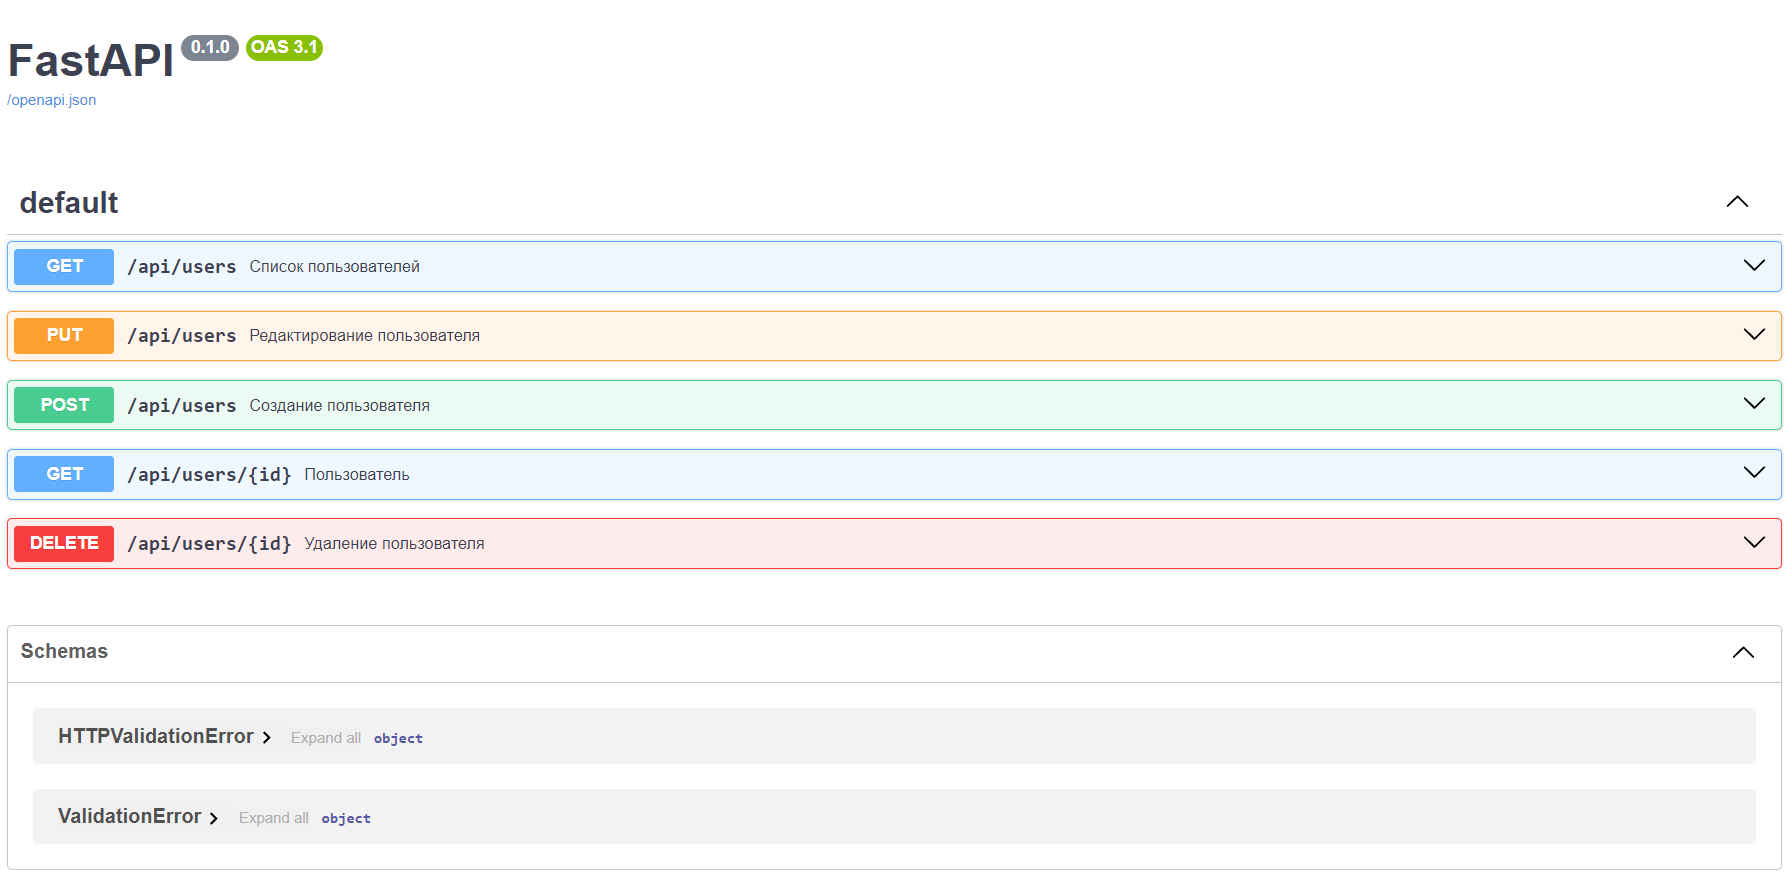

На этом урок подошёл к концу и пора приступить к выполнению [домашней работы](https://colab.research.google.com/drive/1SlJW51-OaUUDPuk-j9GYNHHwFkHBztU_).